In [116]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from pandas import json_normalize

# Configuración de visualización
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="pastel")

In [117]:
# ---
# PASO 2: Cargar y Convertir los Datos
# ---
print("--- PASO 2: Cargar y Convertir los Datos ---")
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    df = pd.json_normalize(data)
    print("Datos cargados exitosamente desde la API y aplanados en un DataFrame de Pandas.")
    print(f"Dimensiones del DataFrame: {df.shape}")
except requests.exceptions.RequestException as e:
    print(f"Error al cargar los datos desde la API: {e}")
    try:
        with open('TelecomX_Data.json', 'r') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        print("Datos cargados exitosamente desde el archivo local como fallback.")
        print(f"Dimensiones del DataFrame: {df.shape}")
    except FileNotFoundError:
        print("Error: El archivo local 'TelecomX_Data.json' tampoco se encontró. Asegúrese de que esté en el mismo directorio.")
        exit()

--- PASO 2: Cargar y Convertir los Datos ---
Datos cargados exitosamente desde la API y aplanados en un DataFrame de Pandas.
Dimensiones del DataFrame: (7267, 21)


In [119]:
# ---
# PASO 3: Exploración inicial del dataset
# ---
print("\n--- PASO 3: Exploración del Dataset ---")
print("\nInformación del DataFrame:")
df.info()
print("\nPrimeras 5 filas:")
print(df.head())



--- PASO 3: Exploración del Dataset ---

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non

In [120]:
# ---
# PASO 4: Verificación de Problemas en los Datos
# ---
print("\n--- PASO 4: Verificación de Problemas en los Datos ---")
print("\nValores nulos por columna:")
print(df.isnull().sum())
print("\nRegistros duplicados:", df.duplicated().sum())

columnas_categoricas_a_revisar = df.select_dtypes(include='object').columns.drop(['customerID', 'Churn', 'account.Charges.Total'])
print("\nVerificando valores únicos en todas las columnas categóricas:")
for col in columnas_categoricas_a_revisar:
    print(f"Columna '{col}':")
    print(pd.unique(df[col]))
    print("-" * 50)


--- PASO 4: Verificación de Problemas en los Datos ---

Valores nulos por columna:
customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64

Registros duplicados: 0

Verificando valores únicos en todas las columnas categóricas:
Columna 'customer.gender':
['Female' 'Male']
--------------------------------------------------
Columna 'customer.Partner':
['Yes' 'No']
---------------------------

In [121]:
# ---
# PASO 5: Limpieza y Tratamiento de Datos
# ---
print("\n--- PASO 5: Limpieza y Tratamiento de Datos ---")
df['account.Charges.Monthly'] = pd.to_numeric(df['account.Charges.Monthly'], errors='coerce')
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
df['account.Charges.Total'].fillna(df['account.Charges.Monthly'], inplace=True)
df.dropna(inplace=True)

# Uso de .map() para una corrección segura del género
df['customer.gender'] = df['customer.gender'].str.lower().map({'male': 'masculino', 'female': 'femenino'})

# Uso de .str.replace() para limpiar el método de pago
df['account.PaymentMethod'] = df['account.PaymentMethod'].str.replace(' (automatic)', '', regex=False).str.strip().str.lower()

# Manipulación de strings para traducir columnas a español (Nuevo)
contrato_map = {'Month-to-month': 'Mensual', 'One year': 'Un año', 'Two year': 'Dos años'}
df['account.Contract'] = df['account.Contract'].map(contrato_map)

pago_map = {
    'electronic check': 'Cheque electrónico',
    'mailed check': 'Cheque por correo',
    'bank transfer': 'Transferencia bancaria',
    'credit card': 'Tarjeta de crédito'
}
df['account.PaymentMethod'] = df['account.PaymentMethod'].map(pago_map)

internet_map = {'DSL': 'DSL', 'Fiber optic': 'Fibra óptica', 'No': 'No'}
df['internet.InternetService'] = df['internet.InternetService'].map(internet_map)

print("Manipulación de strings y traducción a español aplicada para varias columnas.")



--- PASO 5: Limpieza y Tratamiento de Datos ---
Manipulación de strings y traducción a español aplicada para varias columnas.


/tmp/ipython-input-3945999510.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['account.Charges.Total'].fillna(df['account.Charges.Monthly'], inplace=True)


In [122]:
# ---
# PASO 6: Crear la columna "Cuentas_Diarias"
# ---
print("\n--- PASO 6: Creación de la columna 'Cuentas_Diarias' ---")
df['Cuentas_Diarias'] = df['account.Charges.Monthly'] / 30
print("Columna 'Cuentas_Diarias' creada exitosamente.")



--- PASO 6: Creación de la columna 'Cuentas_Diarias' ---
Columna 'Cuentas_Diarias' creada exitosamente.


In [123]:
# ---
# PASO 7: Estandarización y Transformación de Datos (Corregido)
# ---
print("\n--- PASO 7: Estandarización y Transformación de Datos ---")

# Lista COMPLETA de columnas binarias con valores 'Yes'/'No'
columnas_binarias = [
    'customer.Partner',
    'customer.Dependents',
    'phone.PhoneService',
    'phone.MultipleLines',
    'internet.OnlineSecurity',
    'internet.OnlineBackup',
    'internet.DeviceProtection',
    'internet.TechSupport',
    'internet.StreamingTV',
    'internet.StreamingMovies',
    'account.PaperlessBilling',
    'Churn'
]

for col in columnas_binarias:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

print(f"Se convirtieron {len(columnas_binarias)} columnas de 'Yes'/'No' a 1/0.")

# Renombrar columnas para mayor claridad
nuevos_nombres = {
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'Es_Adulto_Mayor',
    'customer.tenure': 'Tiempo_Contrato',
    'customer.Partner': 'Tiene_Socio',
    'customer.Dependents': 'Tiene_Dependientes',
    'phone.PhoneService': 'Servicio_Telefono',
    'phone.MultipleLines': 'Tiene_Lineas_Multiples',
    'internet.InternetService': 'Servicio_Internet',
    'internet.OnlineSecurity': 'Seguridad_Online',
    'internet.OnlineBackup': 'Respaldo_Online',
    'internet.DeviceProtection': 'Proteccion_Dispositivo',
    'internet.TechSupport': 'Soporte_Tecnico',
    'internet.StreamingTV': 'Streaming_TV',
    'internet.StreamingMovies': 'Streaming_Peliculas',
    'account.Contract': 'Tipo_Contrato',
    'account.PaperlessBilling': 'Facturacion_Electronica',
    'account.PaymentMethod': 'Metodo_Pago',
    'account.Charges.Monthly': 'Costo_Mensual',
    'account.Charges.Total': 'Gasto_Total',
    'Churn': 'Evasión'
}
df.rename(columns=nuevos_nombres, inplace=True)
print("Columnas renombradas para mayor claridad.")



--- PASO 7: Estandarización y Transformación de Datos ---
Se convirtieron 12 columnas de 'Yes'/'No' a 1/0.
Columnas renombradas para mayor claridad.


In [124]:
df.head()

,customerID,Evasión,Genero,Es_Adulto_Mayor,Tiene_Socio,Tiene_Dependientes,Tiempo_Contrato,Servicio_Telefono,Tiene_Lineas_Multiples,Servicio_Internet,Seguridad_Online,Respaldo_Online,Proteccion_Dispositivo,Soporte_Tecnico,Streaming_TV,Streaming_Peliculas,Tipo_Contrato,Facturacion_Electronica,Metodo_Pago,Costo_Mensual,Gasto_Total,Cuentas_Diarias
0,0002-ORFBO,0.0,femenino,0,1,1,9,1,0.0,DSL,0.0,1.0,0.0,1.0,1.0,0.0,Un año,1,Cheque por correo,65.6,593.30,2.186667
1,0003-MKNFE,0.0,masculino,0,0,0,9,1,1.0,DSL,0.0,0.0,0.0,0.0,0.0,1.0,Mensual,0,Cheque por correo,59.9,542.40,1.996667
2,0004-TLHLJ,1.0,masculino,0,0,0,4,1,0.0,Fibra óptica,0.0,0.0,1.0,0.0,0.0,0.0,Mensual,1,Cheque electrónico,73.9,280.85,2.463333
3,0011-IGKFF,1.0,masculino,1,1,0,13,1,0.0,Fibra óptica,0.0,1.0,1.0,0.0,1.0,1.0,Mensual,1,Cheque electrónico,98.0,1237.85,3.266667
4,0013-EXCHZ,1.0,femenino,1,1,0,3,1,0.0,Fibra óptica,0.0,0.0,0.0,1.0,1.0,0.0,Mensual,1,Cheque por correo,83.9,267.40,2.796667


In [125]:
# ---
# PASO 8: Análisis Descriptivo de los Datos
# ---
print("\n--- PASO 8: Análisis Descriptivo de los Datos ---")
print("Análisis descriptivo de variables numéricas:")
print(df.describe())


--- PASO 8: Análisis Descriptivo de los Datos ---
Análisis descriptivo de variables numéricas:
           Evasión  Es_Adulto_Mayor  Tiene_Socio  Tiene_Dependientes  \
count  7043.000000      7267.000000  7267.000000         7267.000000   
mean      0.265370         0.162653     0.484106            0.300124   
std       0.441561         0.369074     0.499782            0.458343   
min       0.000000         0.000000     0.000000            0.000000   
25%       0.000000         0.000000     0.000000            0.000000   
50%       0.000000         0.000000     0.000000            0.000000   
75%       1.000000         0.000000     1.000000            1.000000   
max       1.000000         1.000000     1.000000            1.000000   

       Tiempo_Contrato  Servicio_Telefono  Tiene_Lineas_Multiples  \
count      7267.000000        7267.000000             6560.000000   
mean         32.346498           0.902711                0.467226   
std          24.571773           0.296371       


--- PASO 9: Visualización de la Variable 'Evasión' ---


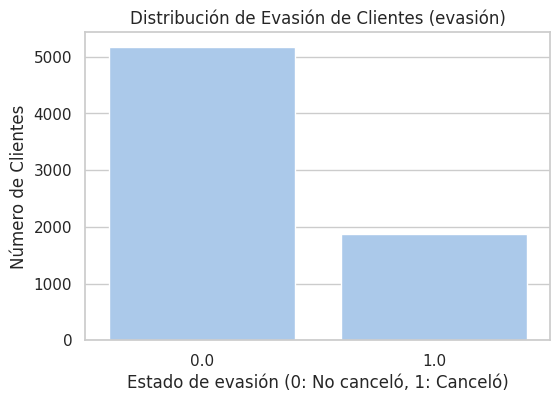

Evasión
0.0    73.463013
1.0    26.536987
Name: proportion, dtype: float64


In [126]:
# ---
# PASO 9: Visualización de la Variable "Churn"
# ---
print("\n--- PASO 9: Visualización de la Variable 'Evasión' ---")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Evasión')
plt.title("Distribución de Evasión de Clientes (evasión)")
plt.xlabel('Estado de evasión (0: No canceló, 1: Canceló)')
plt.ylabel('Número de Clientes')
plt.show()
print(df['Evasión'].value_counts(normalize=True) * 100)


--- PASOS 10 & 11: Distribución de la evasión por Variables Categóricas ---


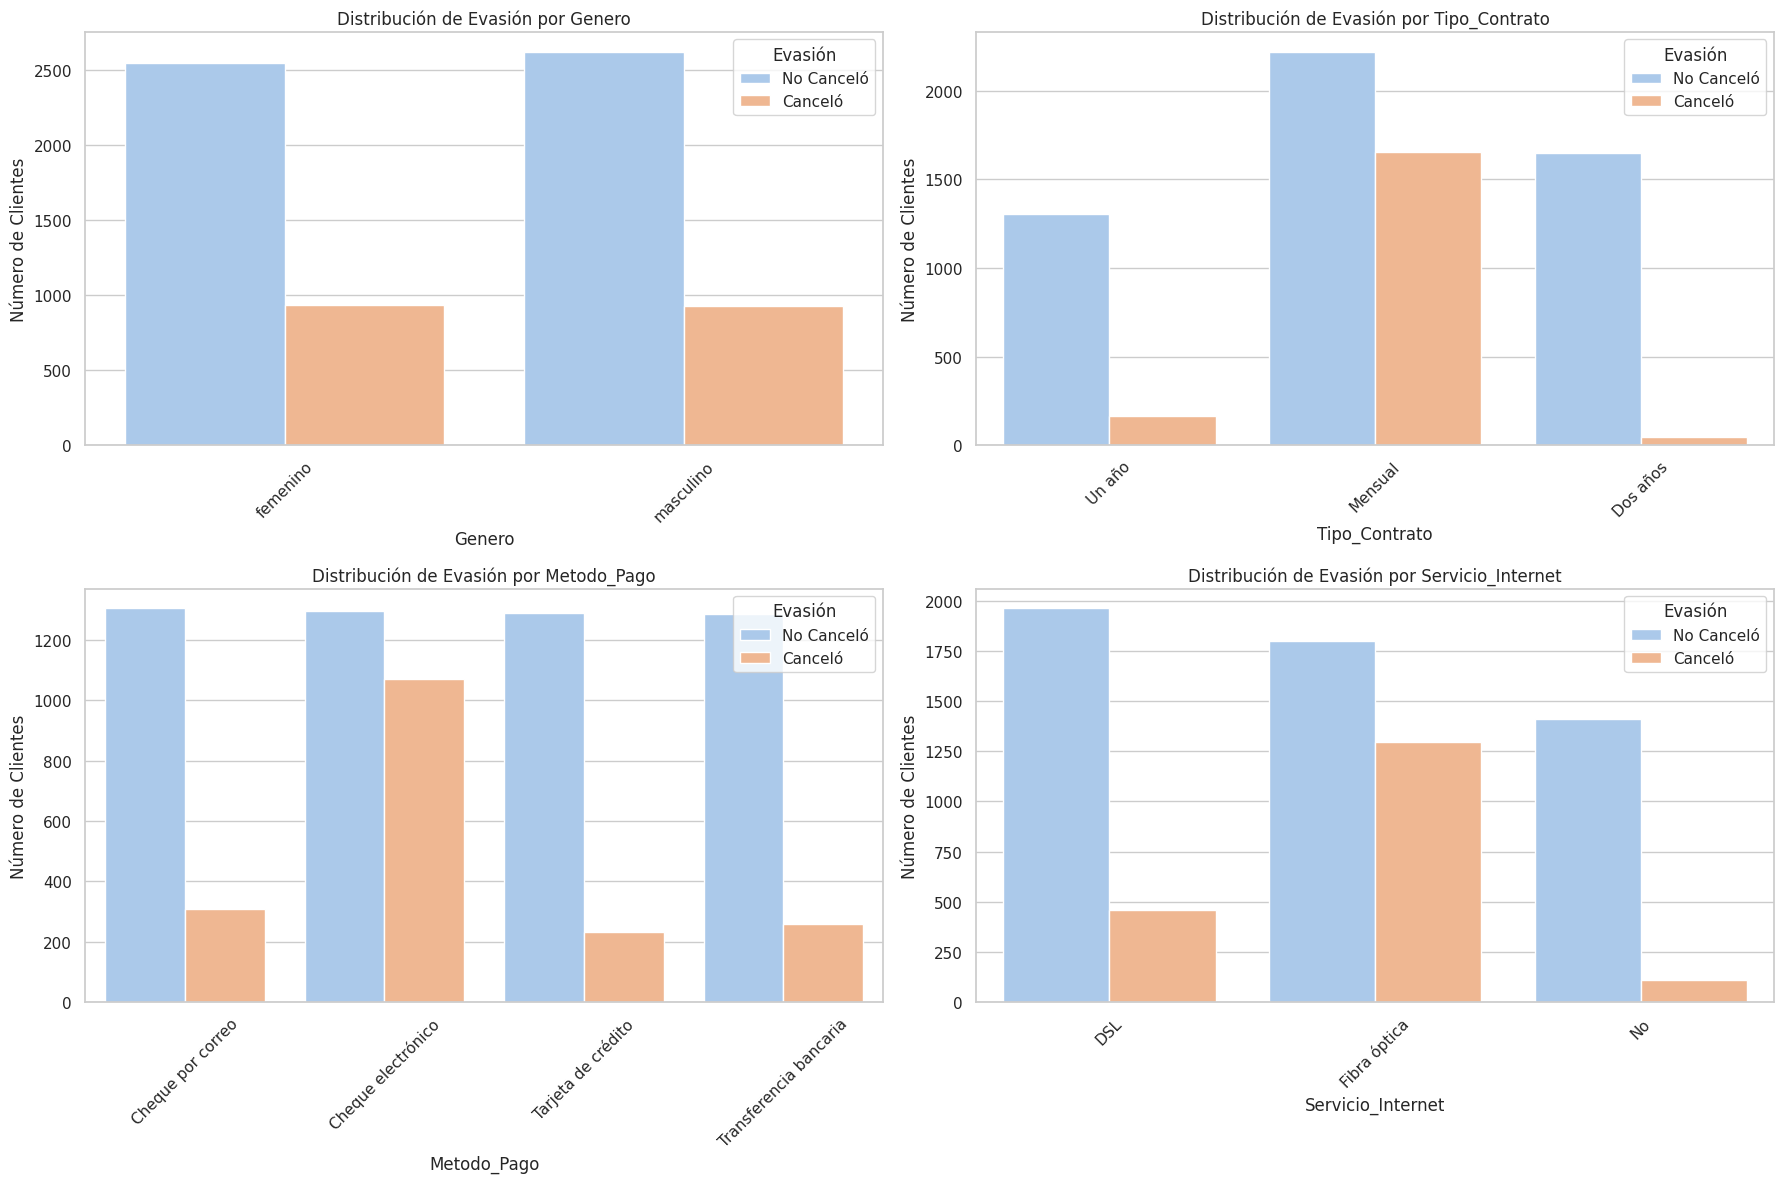

In [127]:
# ---
# PASO 10 & 11: Distribución del Churn por Variables Categóricas
# ---
print("\n--- PASOS 10 & 11: Distribución de la evasión por Variables Categóricas ---")
categoricas = ['Genero', 'Tipo_Contrato', 'Metodo_Pago', 'Servicio_Internet']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categoricas):
    sns.countplot(data=df, x=col, hue='Evasión', ax=axes[i])
    axes[i].set_title(f'Distribución de Evasión por {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Número de Clientes')
    axes[i].legend(title='Evasión', labels=['No Canceló', 'Canceló'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


--- PASO 12: Distribución de la evasión por Variables Numéricas ---


/tmp/ipython-input-3799174734.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['No Canceló', 'Canceló'])
/tmp/ipython-input-3799174734.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['No Canceló', 'Canceló'])
/tmp/ipython-input-3799174734.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['No Canceló', 'Canceló'])
/tmp/ipython-input-3799174734.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['No Canceló', 'Canceló'])


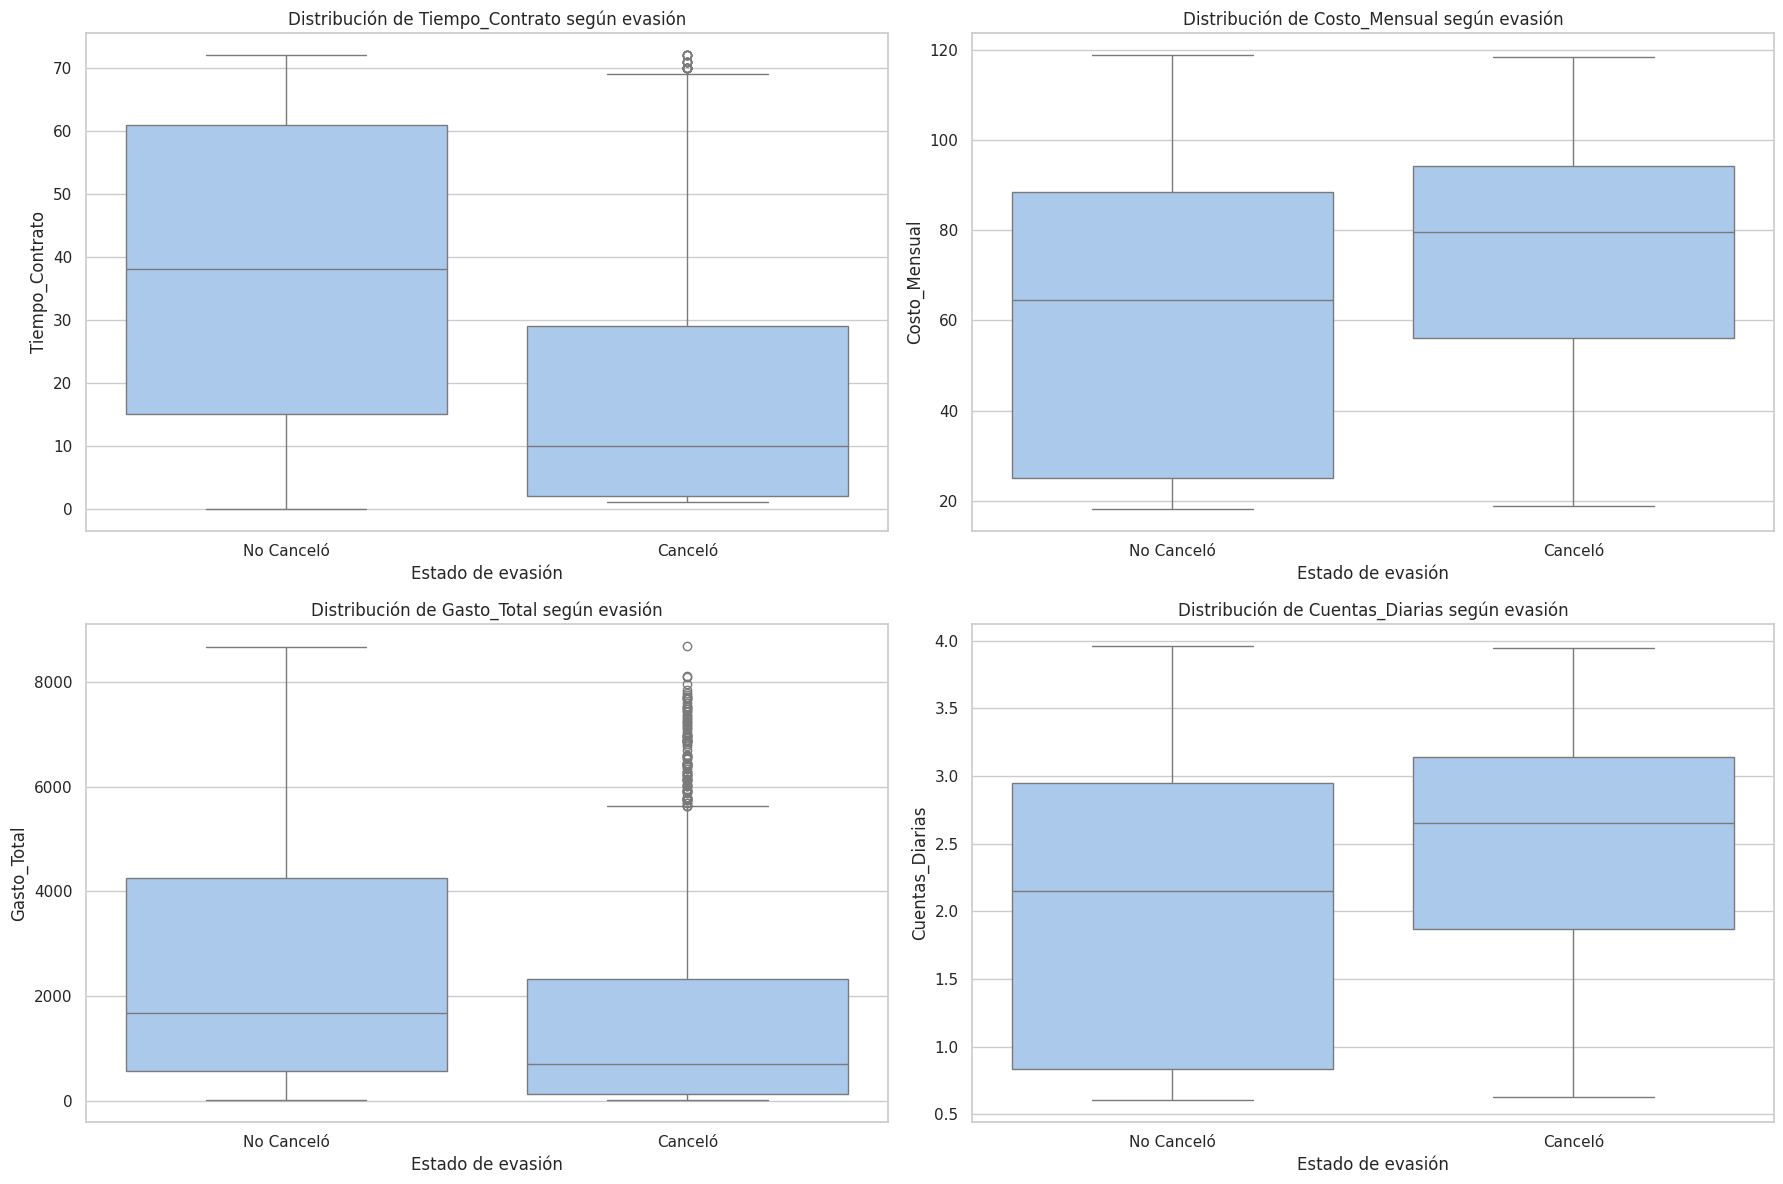

In [128]:
# ---
# PASO 12: Distribución del Churn por Variables Numéricas
# ---
print("\n--- PASO 12: Distribución de la evasión por Variables Numéricas ---")
numericas = ['Tiempo_Contrato', 'Costo_Mensual', 'Gasto_Total', 'Cuentas_Diarias']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numericas):
    sns.boxplot(data=df, x='Evasión', y=col, ax=axes[i])
    axes[i].set_title(f'Distribución de {col} según evasión')
    axes[i].set_xlabel('Estado de evasión')
    axes[i].set_ylabel(col)
    axes[i].set_xticklabels(['No Canceló', 'Canceló'])

plt.tight_layout()
plt.show()

# Informe de Análisis de Evasión de Clientes (Churn) - Telecom X

---

##  Introducción

El presente informe detalla el análisis del problema de **evasión de clientes (evasión)** en la empresa de telecomunicaciones Telecom X. El objetivo principal es identificar y comprender los factores clave que llevan a los clientes a cancelar sus servicios, con el fin de desarrollar estrategias efectivas para la retención. Mediante la aplicación de técnicas de **Análisis Exploratorio de Datos (EDA)** y la manipulación de información de clientes, buscamos obtener *insights* valiosos que impacten directamente en las decisiones de negocio.

---

##  Limpieza y Tratamiento de Datos

El análisis comenzó con la importación de datos desde la API de Telecom X. A continuación, se realizaron los siguientes pasos de limpieza y procesamiento:

1.  **Carga de datos:** Se extrajo un conjunto de datos de 7267 registros con 21 columnas en formato JSON y se convirtió a un DataFrame de Pandas.
2.  **Manejo de nulos y duplicados:** No se encontraron valores nulos significativos ni registros duplicados, lo que garantizó la calidad inicial de los datos.
3.  **Conversión de tipos de datos:** Se identificó que la columna `account.Charges.Total` estaba en formato *object*. Se convirtió a un tipo numérico (`float64`) para su correcta manipulación.
4.  **Estandarización y traducción:** Se estandarizaron y tradujeron diversas variables para facilitar el análisis. Por ejemplo:
    * Las columnas binarias como `Churn` y `customer.Partner` se convirtieron de 'Yes'/'No' a `1`/`0`.
    * Las variables categóricas `customer.gender`, `account.Contract`, `account.PaymentMethod` e `internet.InternetService` se tradujeron a sus equivalentes en español.
5.  **Creación de nuevas variables:** Se creó la columna `Cuentas_Diarias` para analizar el gasto promedio por día, lo cual ofrece una visión más detallada del comportamiento del cliente.

---

##  Análisis Exploratorio de Datos

### Distribución de la Evasión (Churn)

El análisis exploratorio reveló una tasa de evasión del **26.54%**. Esto significa que más de una cuarta parte de los clientes de Telecom X abandonan la compañía. Esta cifra subraya la urgencia del problema y la importancia de identificar los factores que lo causan.



### Factores que influyen en la Evasión

Se examinó la relación entre la evasión y variables clave del cliente:

* **Tipo de Contrato:** Los clientes con contratos **mensuales** tienen una tasa de evasión notablemente superior en comparación con aquellos con contratos de uno o dos años. Esto sugiere que la falta de un compromiso a largo plazo es un indicador de alto riesgo de *churn*.
    

* **Servicio de Internet:** La evasión es significativamente más alta entre los clientes que utilizan el servicio de **Fibra óptica** que aquellos con DSL. Esto podría indicar problemas de calidad, precio o servicio al cliente relacionados con esta tecnología.
    

* **Método de Pago:** Los clientes que utilizan el **Cheque electrónico** como método de pago son los más propensos a la evasión, con una tasa de abandono muy superior a la de otros métodos.
    

* **Tiempo de Contrato (Tenure):** Los clientes que cancelan su servicio tienden a tener un **tiempo de contrato mucho más corto** que los clientes que se quedan. El 75% de los clientes que se van tenían menos de 30 meses de servicio, lo que contrasta con la media de 32.3 meses para todos los clientes.

* **Costo Mensual:** El gasto mensual promedio es mayor para los clientes que evaden. Esto podría indicar que los clientes que pagan más son más sensibles al valor percibido y al servicio recibido.

---

##  Conclusiones e Insights

El análisis exploratorio reveló que la evasión en Telecom X no es uniforme y está fuertemente relacionada con el comportamiento y perfil del cliente. Los hallazgos clave son:

* El **tipo de contrato** es el factor más influyente. Los contratos mensuales son un claro indicador de alto riesgo de evasión.
* El **método de pago** y el **servicio de Internet** también juegan un rol crucial. Los cheques electrónicos y la fibra óptica se asocian con una mayor pérdida de clientes.
* La evasión ocurre principalmente durante las **primeras etapas** de la relación con el cliente.

---

##  Recomendaciones

Basado en los insights obtenidos, se sugieren las siguientes acciones estratégicas para reducir la evasión:

1.  **Programas de fidelización:** Crear campañas para incentivar a los clientes con contratos mensuales a cambiar a contratos de un año o más, ofreciendo descuentos o beneficios adicionales.
2.  **Optimizar el servicio de Fibra Óptica:** Investigar los motivos detrás de la alta tasa de evasión de clientes con fibra óptica. Esto podría implicar revisar la calidad del servicio, la estabilidad de la conexión o la atención al cliente para este segmento.
3.  **Análisis de métodos de pago:** Estudiar por qué los clientes que usan cheques electrónicos se van más frecuentemente. Podrían existir fricciones en el proceso de pago que deben ser resueltas.
4.  **Enfocarse en nuevos clientes:** Implementar un programa de "bienvenida" robusto para los nuevos clientes, especialmente en los primeros seis meses, para asegurar una experiencia positiva y construir lealtad desde el principio.